In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyale

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
np.int = int
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import shuffle
import shap
shap.initjs()
from PyALE import ale
from scipy.stats import friedmanchisquare
import itertools
from rdkit import Chem
from rdkit.Chem import AllChem

In [223]:
#read input data
df_input = pd.read_csv('input_single.csv', index_col=0)
df_input = df_input.transpose()

# ECFP fingerprints calculation
def compute_ecfp(smiles):
    if smiles is not None:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            return ecfp.ToBitString()
    return None

# Apply the function to the 'SMILES' column and create a new column for ECFP fingerprints

df_input['ECFP main']=df_input['SMILES main compound acid'].apply(lambda x: compute_ecfp(x) if pd.notna(x) else None)

ecfp_main_real = PCA(n_components=1).fit_transform(df_input['ECFP main'].apply(lambda x: pd.Series(map(float, x)) if pd.notna(x) else None))
df_input.insert(loc=df_input.columns.get_loc('SMILES main compound acid'), column='ECFP main real', value=ecfp_main_real)

df_input = df_input.transpose()

#filter input data
indices_to_remove_input = ['experimentalist', 'name main compund acid', 'c total', 'SMILES main compound acid', 'name 2nd compound acid', 'SMILES 2nd compound acid', 'name 3rd compound acid', 'SMILES 3rd compound acid', 'time', 'cathode material', 'cathode area [cm^2 ]', 'anode material']
filtered_input = df_input.drop(indices_to_remove_input)
filtered_input = filtered_input.fillna(0) # fill  empty cells with 0
filtered_input = filtered_input.transpose() # change positions of columns and rows
filtered_input = filtered_input.loc[:, :'anode tafel slope pH7 0.25M Na2SO4 [mAcm-2V-1]'] # remove columns after certain column
#print(filtered_input)

#filter output data
df_output = pd.read_csv('input_single.csv', index_col=0)
filtered_output = df_output.loc['acid conversion [%]':, :,] # remove columns after certain column
filtered_output = filtered_output.fillna(0) # fill  empty cells with 0
filtered_output = filtered_output.transpose() # change positions of columns and rows
#print(filtered_output)

output = 'Yalkane total acid [%]'
output_name = 'total yield [%]' # for correlation matrix
X = filtered_input.values
Y = filtered_output[output].values
X = X.astype(float) # change to float for knn
Y = Y.astype(float) # change to float for knn
print(len(filtered_input.iloc[0]))
#print(filtered_input.iloc[0])
features = []
feature_names = ['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment','dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope']
x=0
for i in feature_names:
    features.append(x)
    x += 1
print(len(feature_names))    
#print(features)
#print(len(feature_names))
random_state_counter = 49

25
25


In [226]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
knn_regressor = Pipeline([
    ('scaler_std', StandardScaler()),
    ('scaler_minmax', MinMaxScaler()),  
    ('knn', KNeighborsRegressor(n_neighbors=3, weights='distance', p=2))
])

knn_regressor.fit(X_train, Y_train)

Y_predict_train_knn = knn_regressor.predict(X_train)
Y_predict_test_knn = knn_regressor.predict(X_test)


mse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn)
rmse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn, squared=False)
r2_train_knn = r2_score(Y_train, Y_predict_train_knn)

mse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn)
rmse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn, squared=False)
r2_test_knn = r2_score(Y_test, Y_predict_test_knn)

print("MSE on train set:", mse_train_knn )
print("RMSE on train set:", rmse_train_knn)
print("R2 on train set:", r2_train_knn)
print("MSE on test set:", mse_test_knn )
print("RMSE on test set:", rmse_test_knn)
print("R2 on test set:", r2_test_knn)


MSE on train set: 4.868959318746252e-13
RMSE on train set: 6.977792859311784e-07
R2 on train set: 0.999999999999996
MSE on test set: 60.37530866818019
RMSE on test set: 7.770154996406455
R2 on test set: 0.6229028006388019


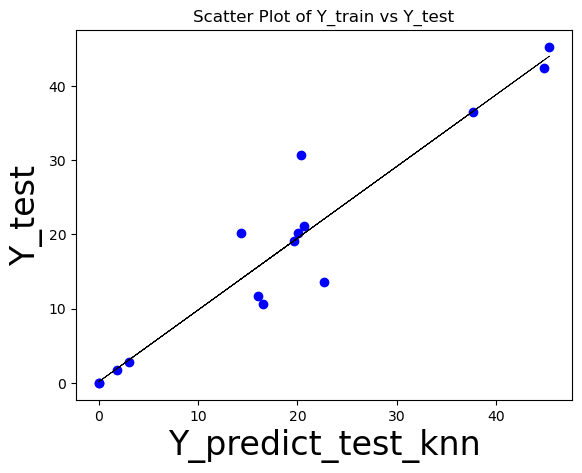

In [206]:
# Linear fit
slope, intercept = np.polyfit(Y_predict_test_knn, Y_test, 1)
fit_line = slope * Y_predict_test_knn + intercept

plt.plot(Y_predict_test_knn, fit_line, color='black', linestyle='-', label='Linear Fit', lw=0.5)
plt.scatter(Y_predict_test_knn, Y_test, color='blue', label='Scatter Points')
plt.title('Scatter Plot of Y_train vs Y_test')
plt.xlabel('Y_predict_test_knn')
plt.ylabel('Y_test')
#plt.xlim([2, 36])  # Set x-axis range
#plt.ylim([2, 36])  # Set y-axis range
plt.show()

['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment', 'dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope']
['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment', 'dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope']
26
['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment', 'dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope', 'total yield [%]']


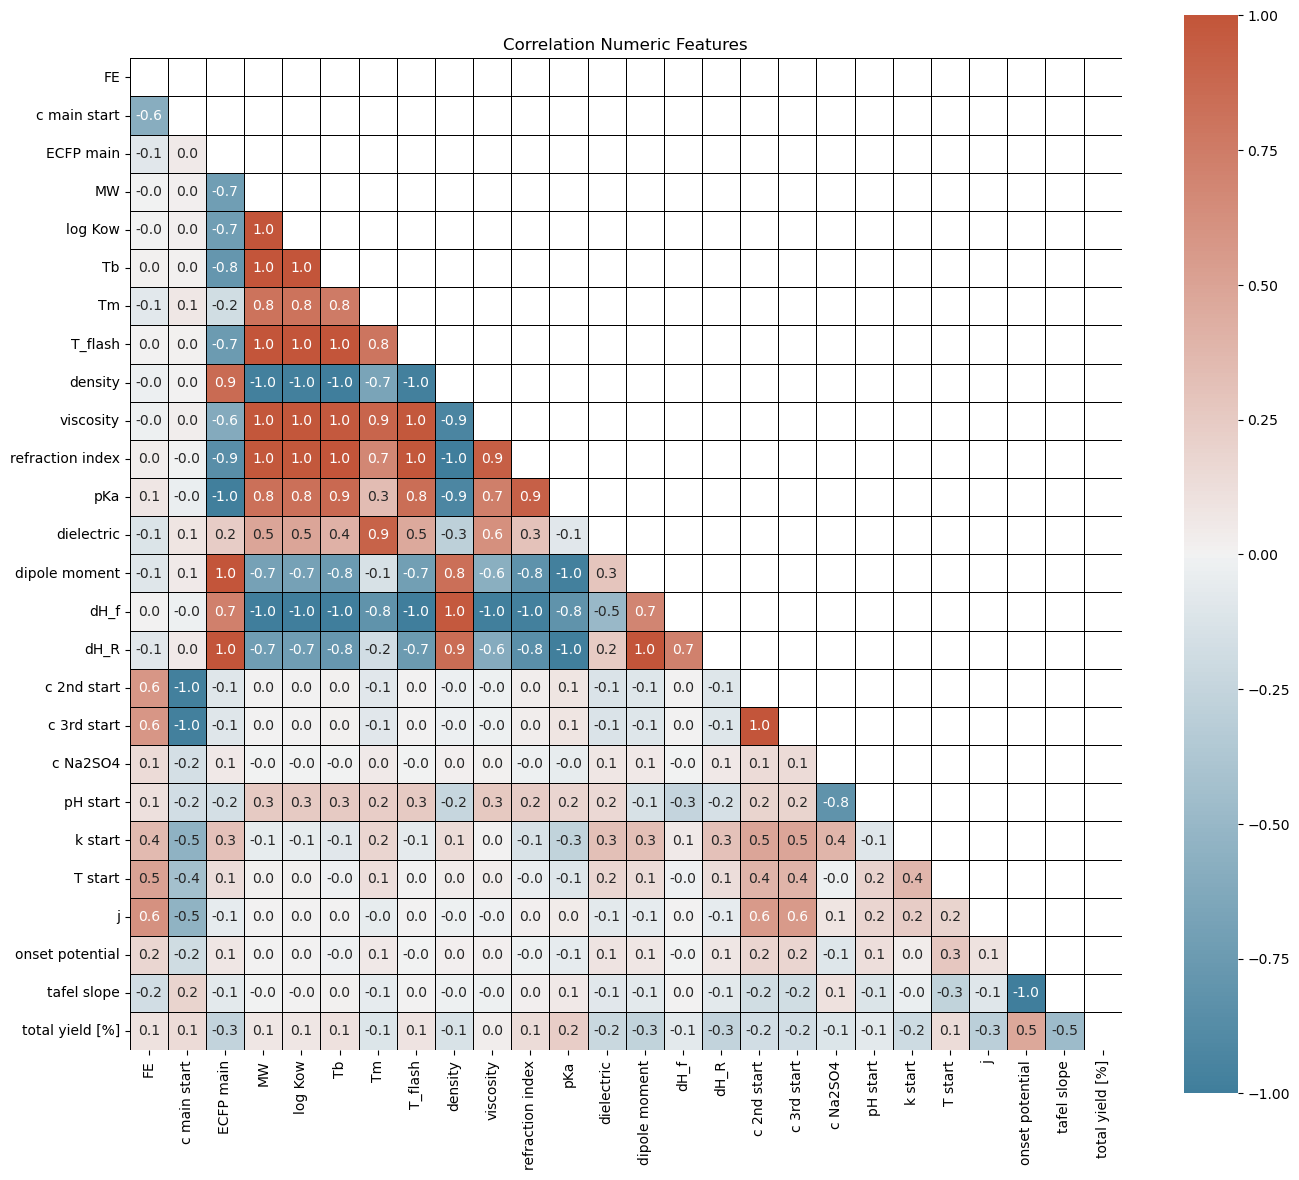

In [208]:
# correlation matrix
feature_namesXY = feature_names.copy()

feature_namesXY.append(output_name)

print(len(feature_namesXY))
print(feature_namesXY)


df_XY = filtered_input
df_XY[output_name] = filtered_output[output]
df_XY.columns = feature_namesXY # change name

corr_df = df_XY.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.1f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

In [209]:
# SHAPLEY values
#explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
#instance_index = 7  # Replace with the index of the instance you want to explain
#shap_value = explainer.shap_values(X_test[instance_index])
#shap.force_plot(explainer.expected_value, shap_value, X_test[instance_index], feature_names=feature_names)

100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


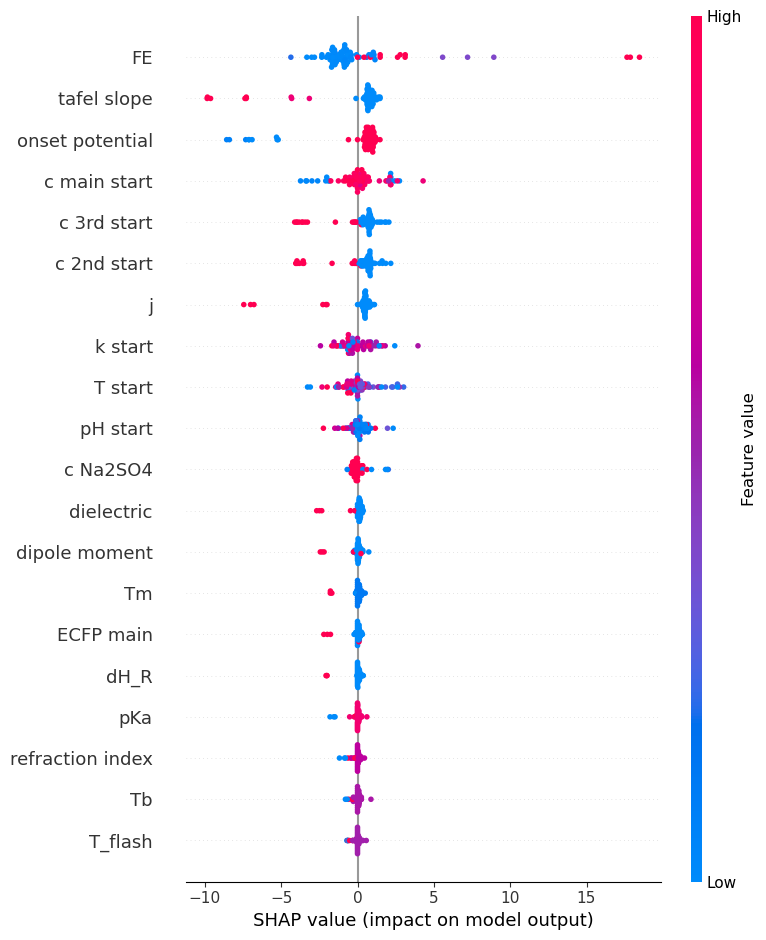

In [125]:
shap_data = X
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data, feature_names=feature_names)

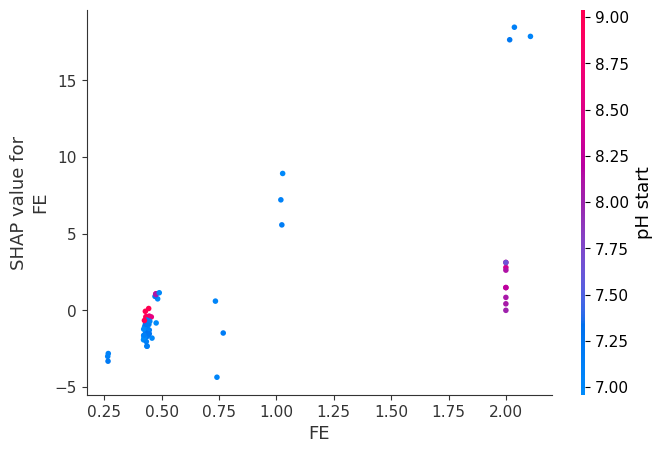

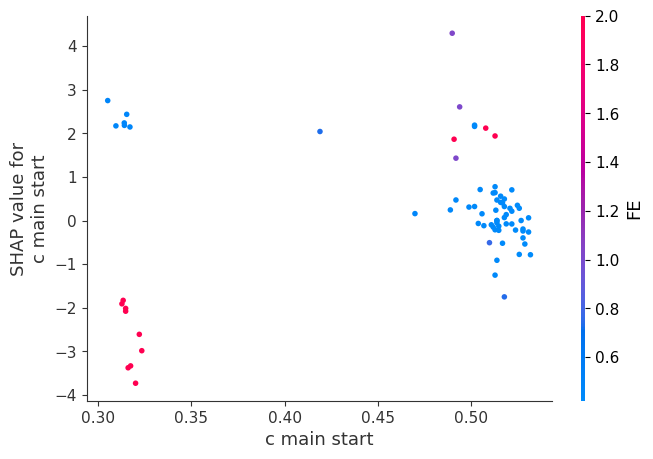

In [127]:
# Create a SHAP dependence plot

feature_index=0
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=1
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

#for i in features:
    #shap.dependence_plot(i, shap_values, shap_data, feature_names=feature_names)

In [128]:
df_test=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test_knn})
print(df_test)

         test  prediction
0    1.752000    1.861629
1   13.630463   22.685700
2   45.275000   45.344807
3    0.000000    0.000000
4   21.116173   20.703598
5   20.165000   14.297342
6   42.457000   44.757612
7   19.153000   19.685571
8   10.670000   16.568987
9   30.736000   20.318386
10  20.158000   20.058277
11   0.000000    0.000000
12  36.499000   37.664772
13  11.706000   16.040816
14   2.765252    3.036072


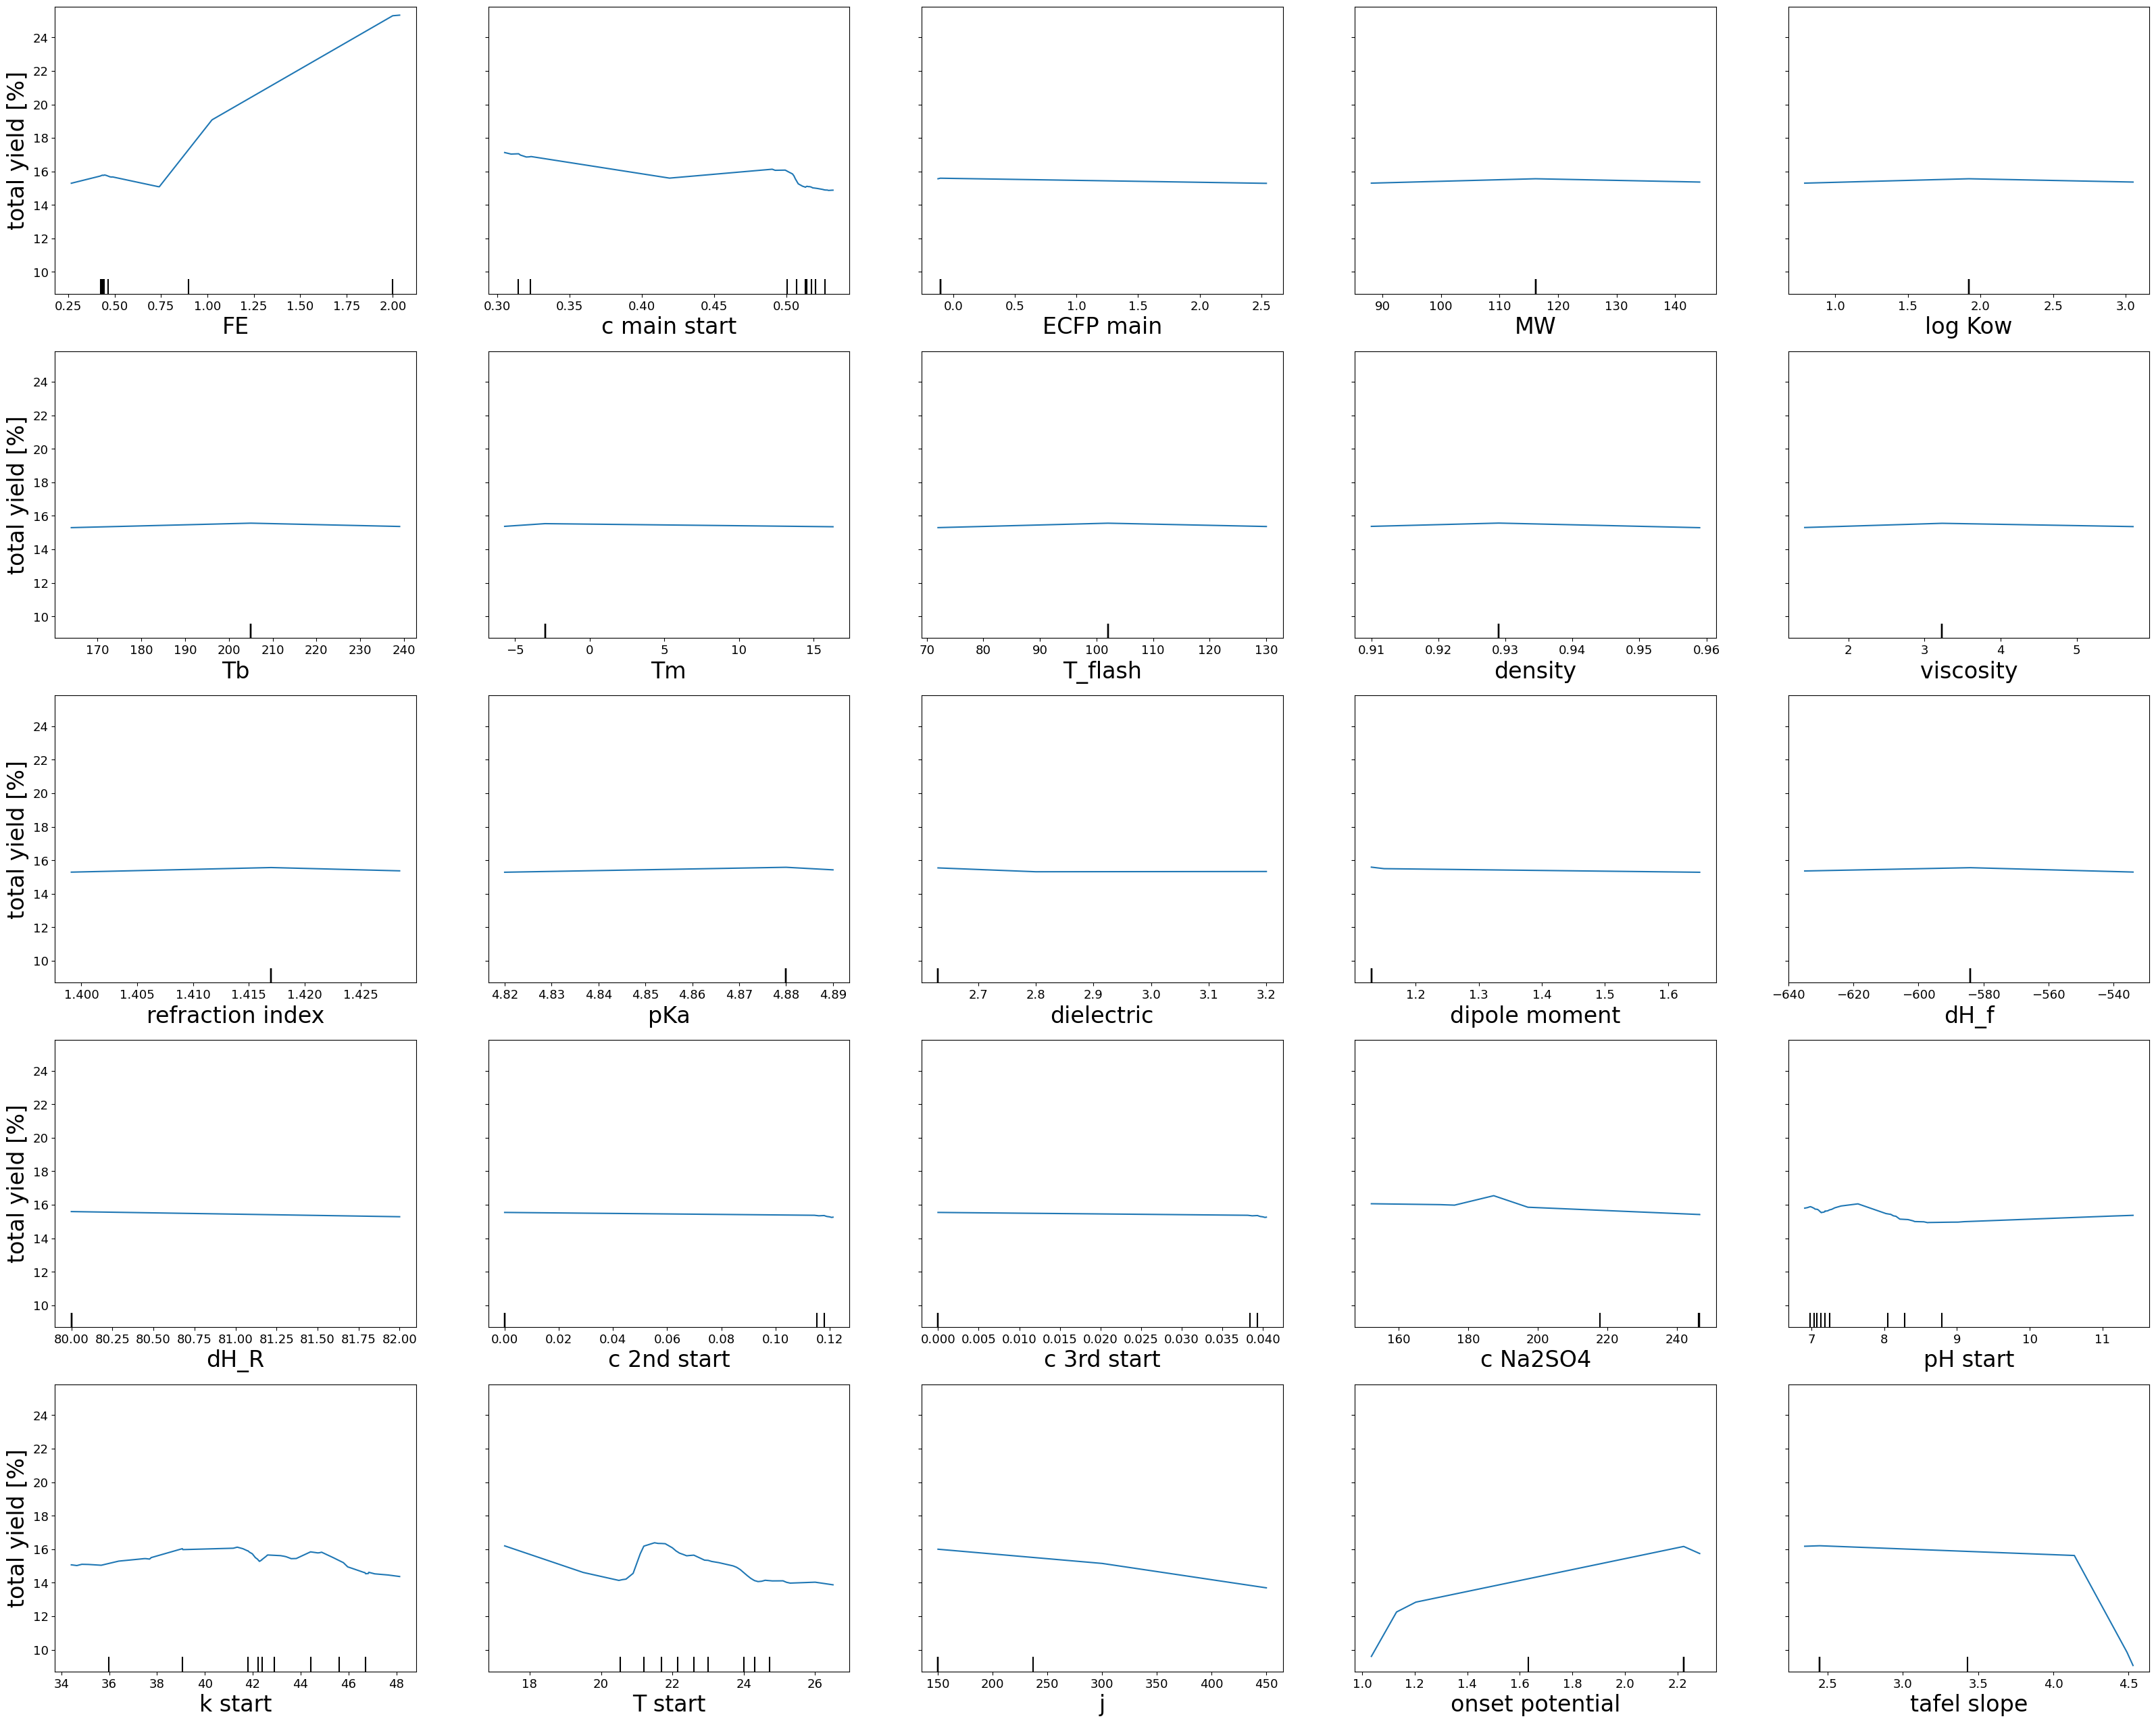

In [142]:
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax#, line_kw={"color": "green"}
                                                 )

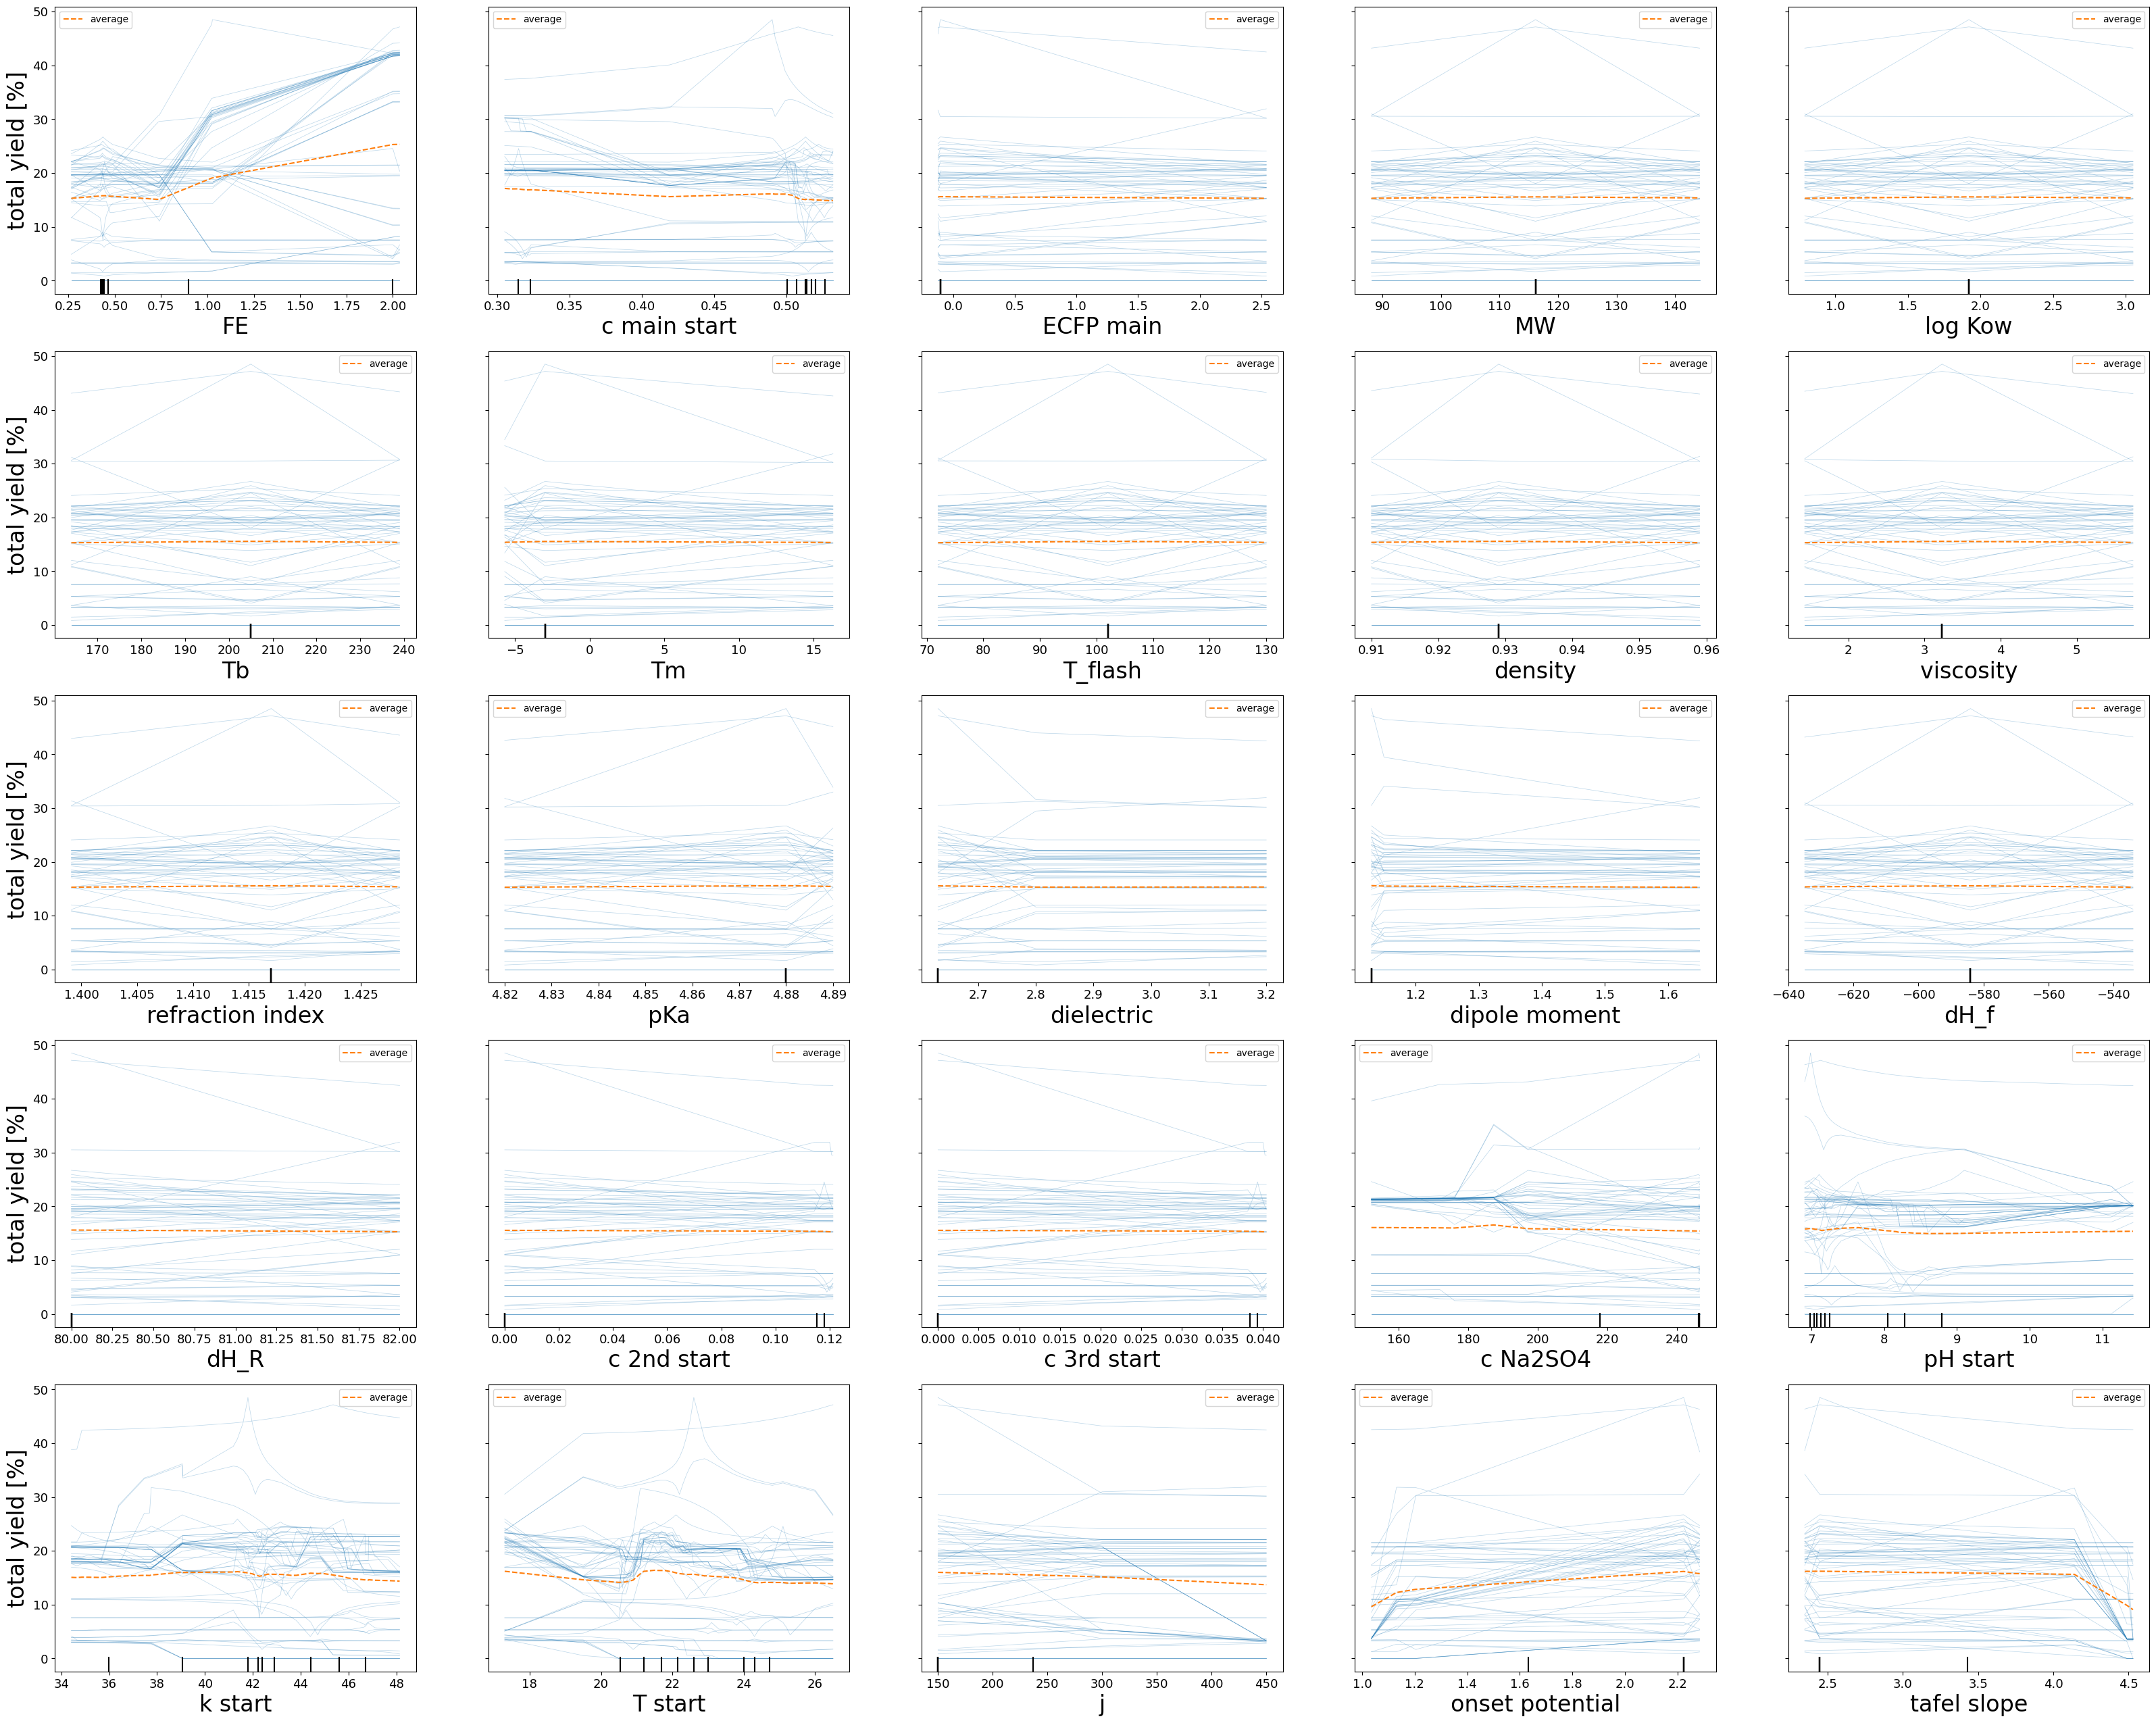

In [143]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax#, line_kw={"color": "green"}
                                                 )

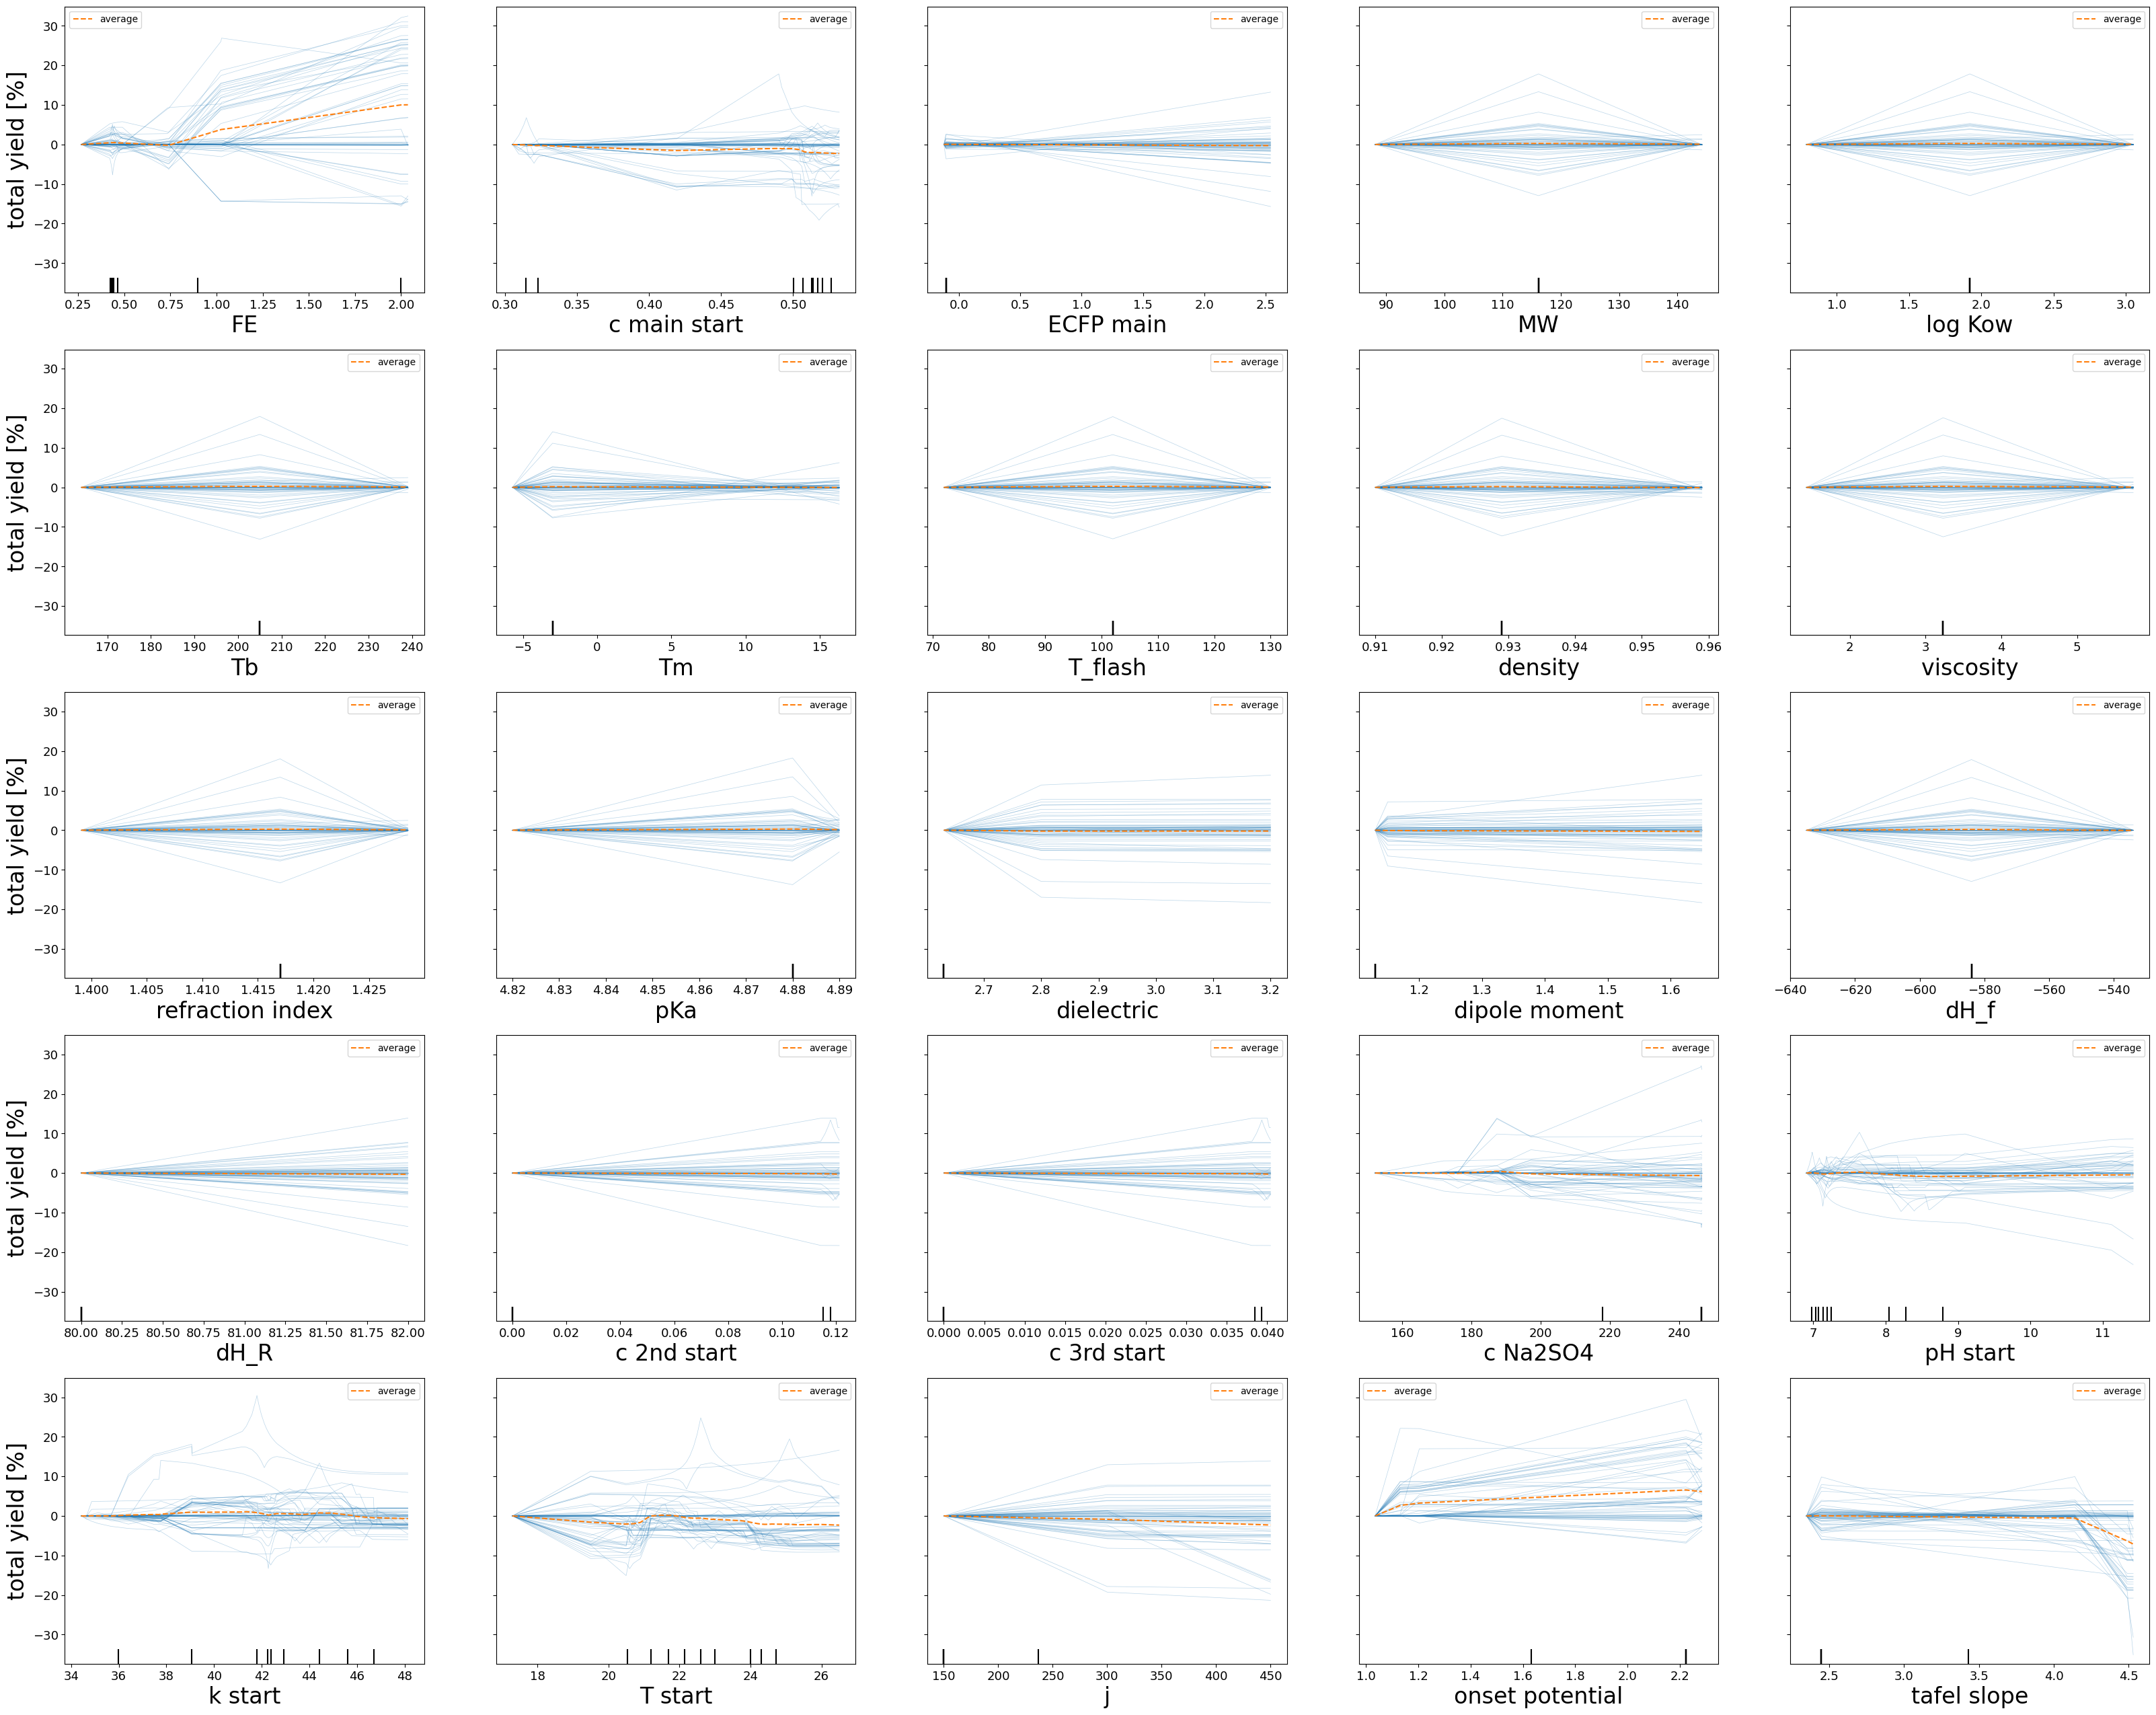

In [144]:
# cICE (centered ICE) and PDP
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', centered=True, ax=ax#, line_kw={"color": "green"}
                                                 )

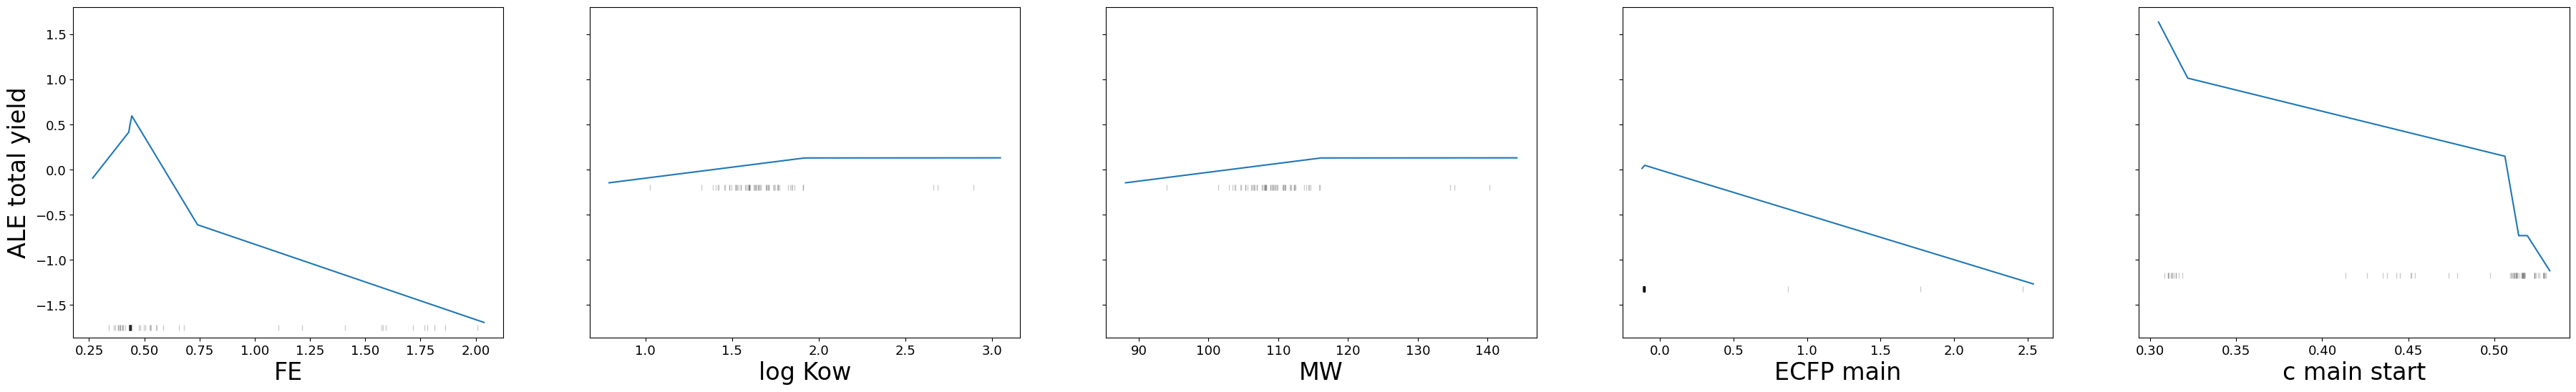

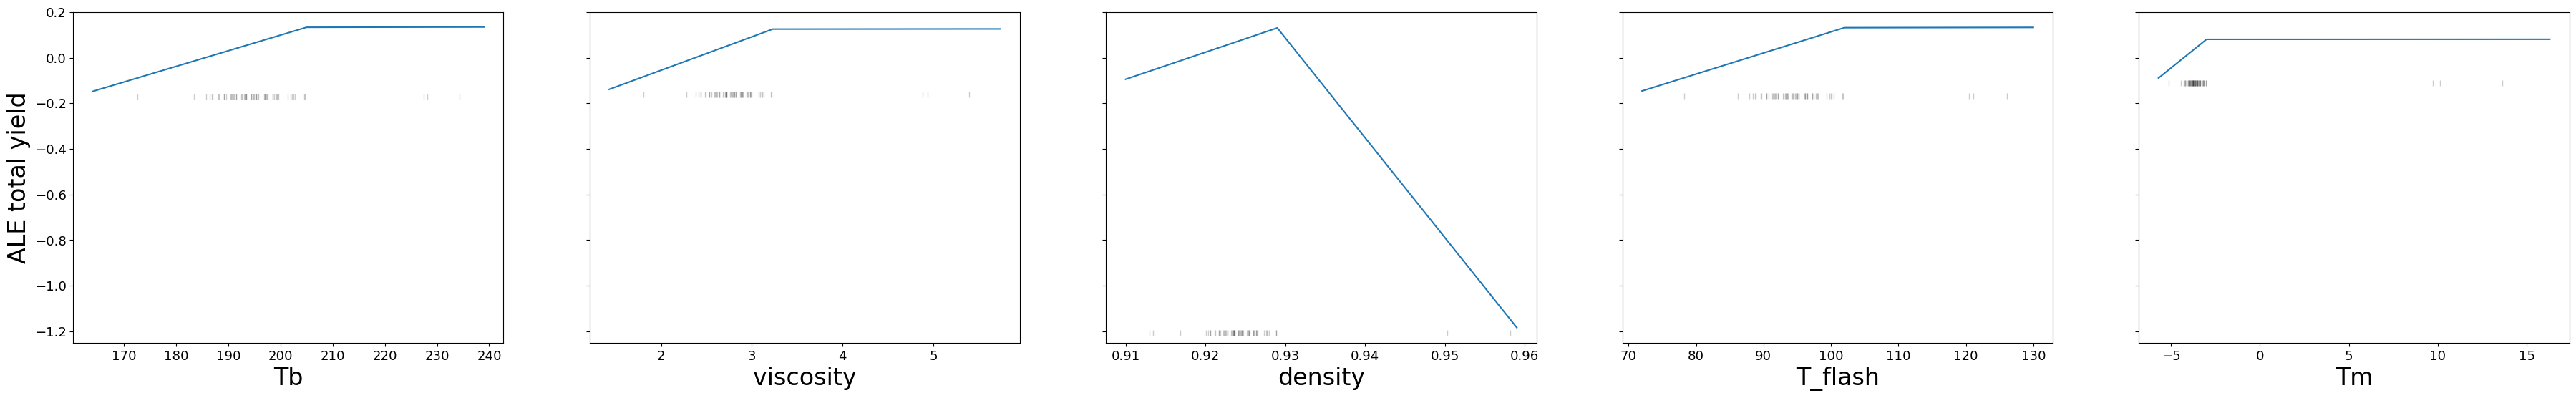

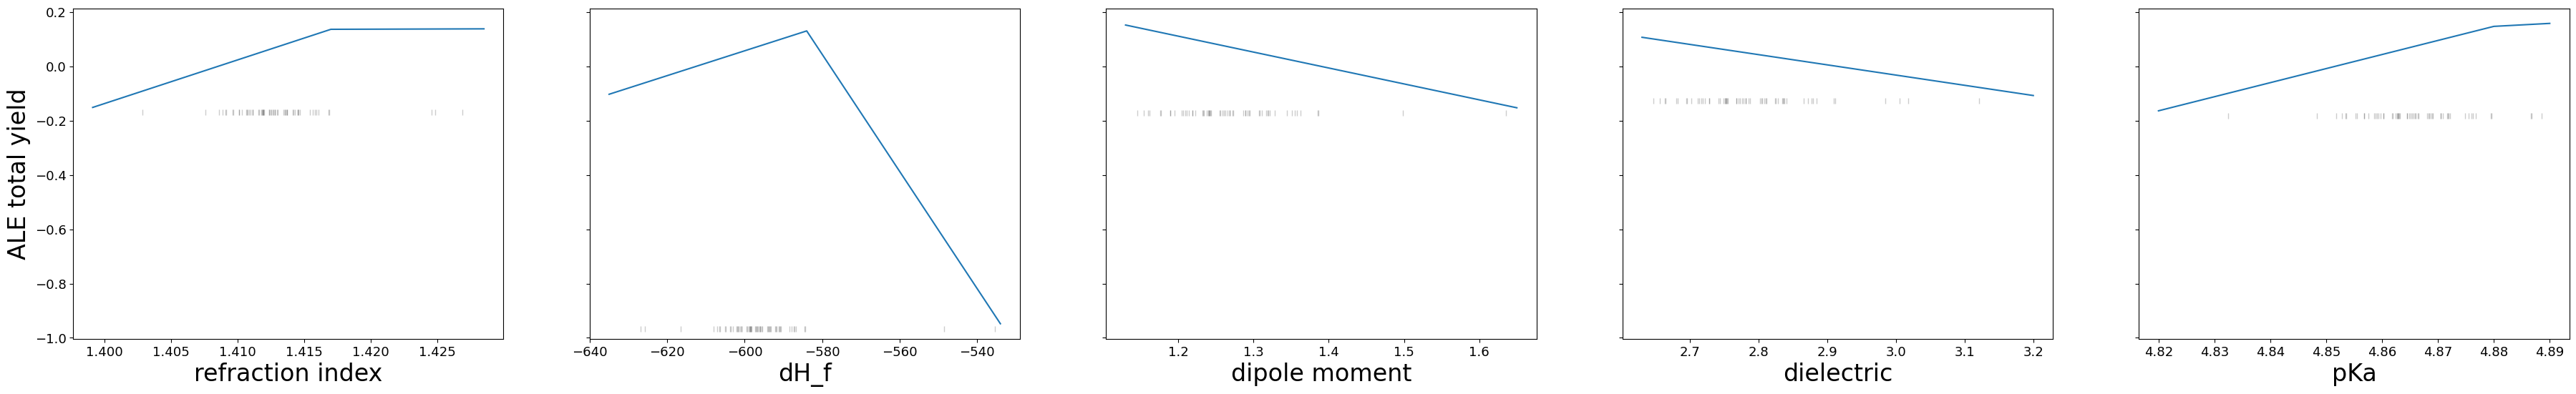

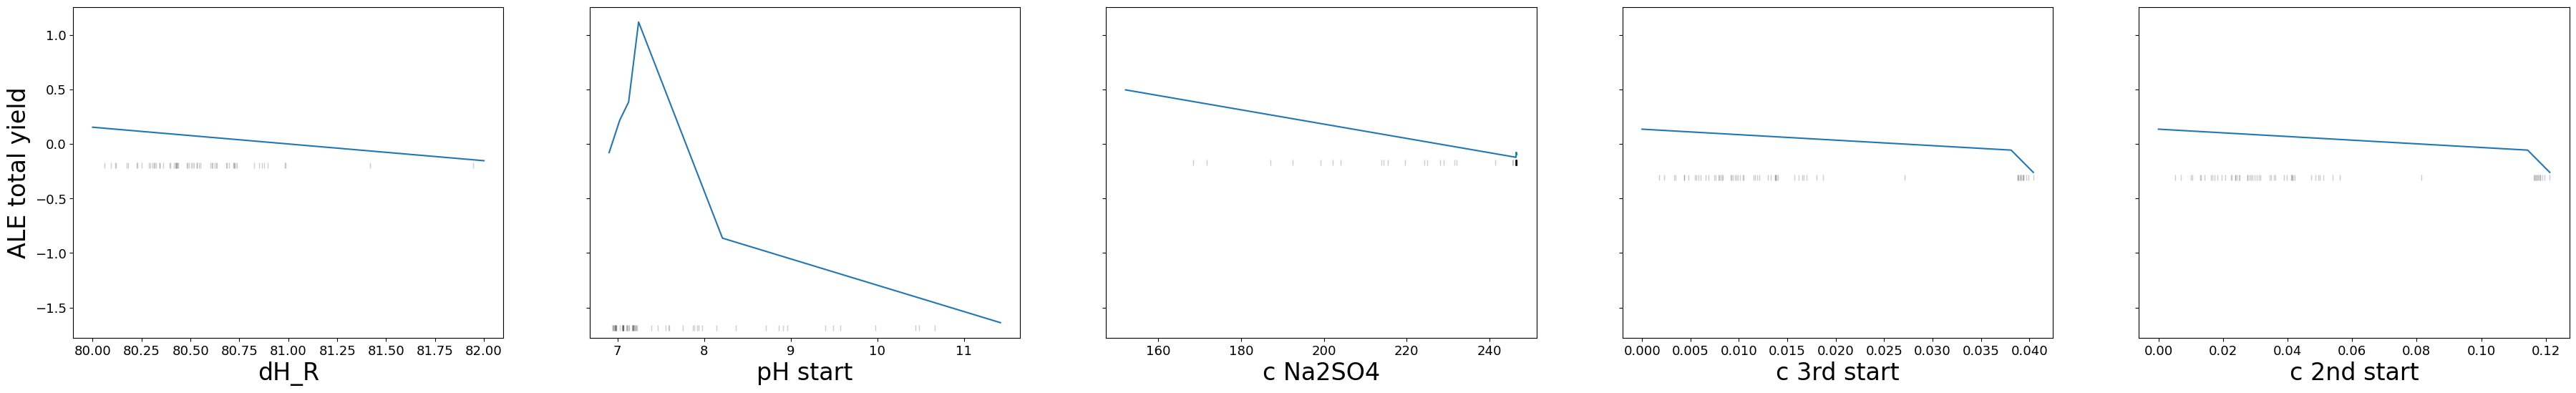

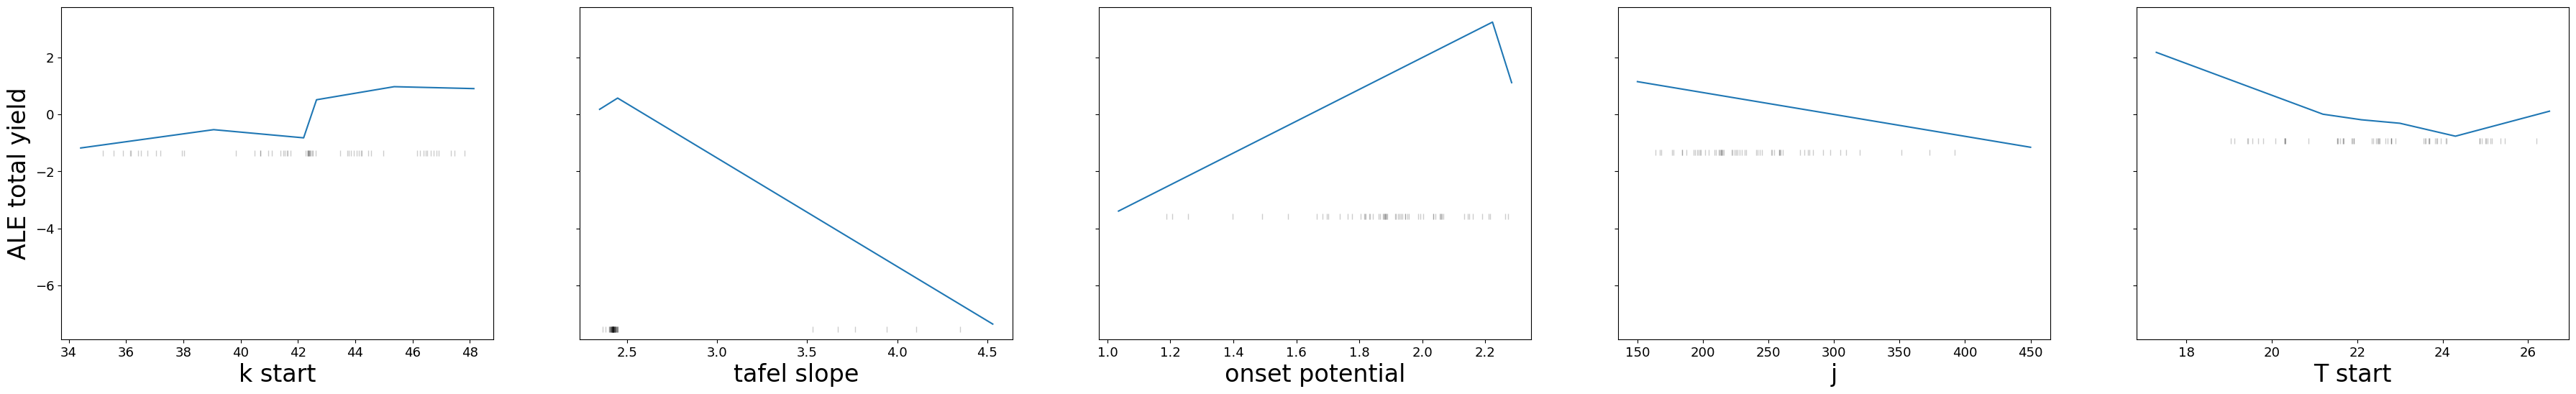

In [156]:
df_train_X = pd.DataFrame(X_train, columns=features)
df_train_Y = pd.DataFrame(Y_train, columns=[output_name])

# get ALE plot

for i in features:
    if i % 5 == 0:
        fig, ax = plt.subplots(ncols=ncols, figsize=(45,6), sharey=True)
        for axis in ax.flatten():
            axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
        ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[0]
        )
        ax[0].set_ylabel('ALE total yield')
        ax[0].set_xlabel(feature_names[i])
        ax[0].set_title('')
    else:
        if (i+1) % 5 == 0:
            ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[1]
            )
            ax[1].set_ylabel('')
            ax[1].set_xlabel(feature_names[i])
            ax[1].set_title('')
        else:
            if (i+2) % 5 == 0:
                ale_eff = ale(
                X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                fig=fig, ax=ax[2]
                )
                ax[2].set_ylabel('')
                ax[2].set_xlabel(feature_names[i])
                ax[2].set_title('')
            else:
                if (i+3) % 5 == 0:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[3]
                    )
                    ax[3].set_ylabel('')
                    ax[3].set_xlabel(feature_names[i])
                    ax[3].set_title('')
                else:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[4]
                    )
                    ax[4].set_ylabel('')
                    ax[4].set_xlabel(feature_names[i])
                    ax[4].set_title('')
    

In [157]:
# 2D ale plots


#ax.set_ylabel('ALE total yield')
#ax.set_xlabel(feature_names[i])
#ax.set_title('')



                      Mean   Std Dev
FE                0.195311  0.275431
c main start      0.112471  0.121371
ECFP main         0.000000  0.000000
MW                0.000000  0.000000
log Kow           0.000000  0.000000
Tb                0.000000  0.000000
Tm                0.000000  0.000000
T_flash           0.000000  0.000000
density           0.000000  0.000000
viscosity         0.000000  0.000000
refraction index  0.000000  0.000000
pKa               0.000000  0.000000
dielectric        0.000000  0.000000
dipole moment     0.000000  0.000000
dH_f              0.000000  0.000000
dH_R              0.000000  0.000000
c 2nd start       0.019785  0.057222
c 3rd start       0.017432  0.040098
c Na2SO4         -0.018721  0.029806
pH start          0.065790  0.081075
k start           0.149209  0.120252
T start           0.083239  0.081097
j                 0.026592  0.044542
onset potential   0.228183  0.143441
tafel slope       0.120709  0.080953


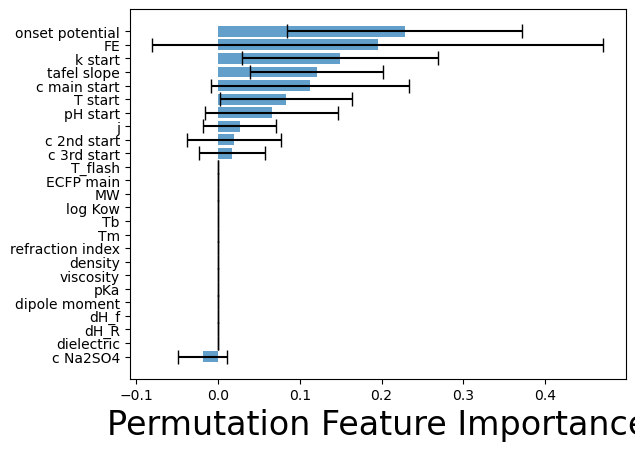

In [228]:
# permutation feature importance on test data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()

                      Mean   Std Dev
FE                0.056809  0.018890
c main start      0.045350  0.007371
ECFP main         0.036783  0.001020
MW                0.036783  0.001020
log Kow           0.036783  0.001020
Tb                0.036783  0.001020
Tm                0.036783  0.001020
T_flash           0.036783  0.001020
density           0.036783  0.001020
viscosity         0.036783  0.001020
refraction index  0.036783  0.001020
pKa               0.036783  0.001020
dielectric        0.036783  0.001020
dipole moment     0.036783  0.001020
dH_f              0.036783  0.001020
dH_R              0.036783  0.001020
c 2nd start       0.038016  0.002718
c 3rd start       0.038037  0.002923
c Na2SO4          0.035619  0.001919
pH start          0.042002  0.005282
k start           0.047619  0.008217
T start           0.042683  0.005192
j                 0.038779  0.003406
onset potential   0.054709  0.008752
tafel slope       0.045421  0.003630


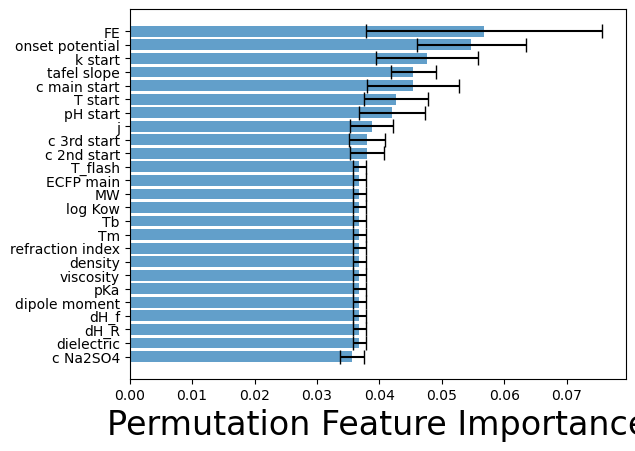

In [229]:
# permutation feature importance on training data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_train)
baseline_mse = mse(Y_train, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_train.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()